# Assignment 4

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [3]:
G1 = nx.read_gpickle("assets/A4_P1_G1")
G2 = nx.read_gpickle("assets/A4_P1_G2")
G3 = nx.read_gpickle("assets/A4_P1_G3")
G4 = nx.read_gpickle("assets/A4_P1_G4")
G5 = nx.read_gpickle("assets/A4_P1_G5")
P1_Graphs = [G1, G2, G3, G4, G5]

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs using any methodology and determine which of the three algorithms generated each graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [91]:
def graph_identification():
    # YOUR CODE HERE
    import matplotlib.pyplot as plt
    Algo = []
    for G in P1_Graphs:
        degree = dict(G.degree())
        G_value = sorted(set(degree.values()))
        hist =[list(degree.values()).count(i)/float(nx.number_of_nodes(G))
                                                    for i in G_value]
        
        plt.bar(G_value,hist)
        plt.xlabel('degree')
        plt.ylabel('fraction of degree')
        plt.show()
        cluster = nx.average_clustering(G)
        path = nx.average_shortest_path_length(G) 
        
        
        if max(degree.values())>15:
            Algo.append('PA')
        elif cluster>0.4 and path>10:
            Algo.append('SW_L')
        else:
            Algo.append('SW_H')
    return Algo
    raise NotImplementedError()

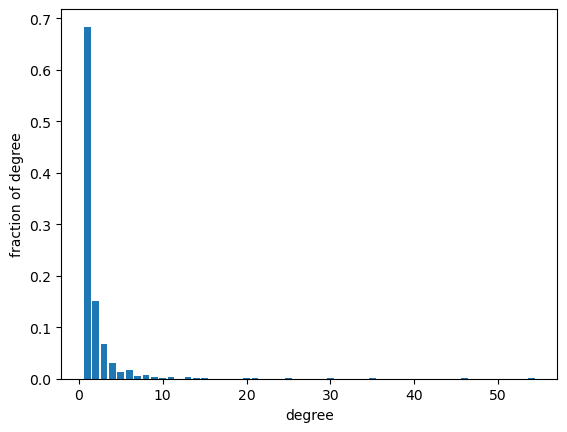

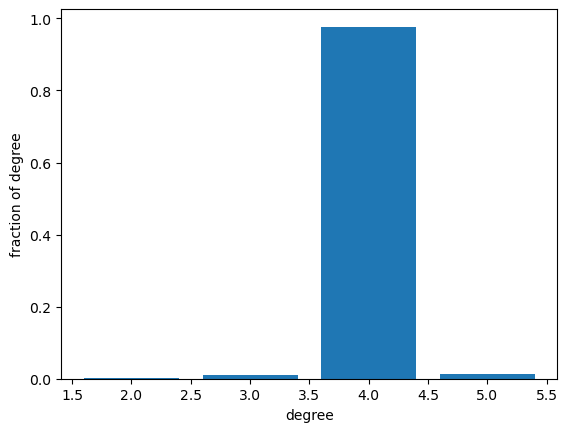

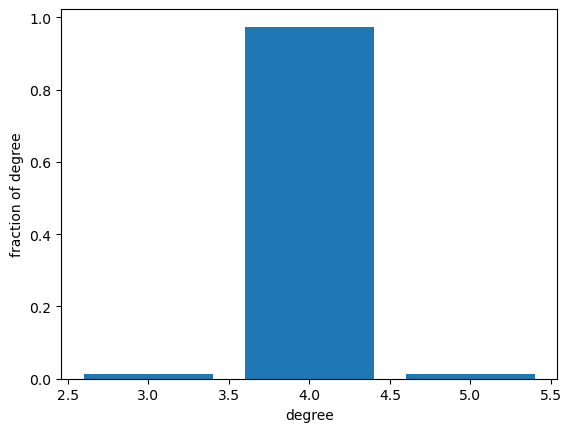

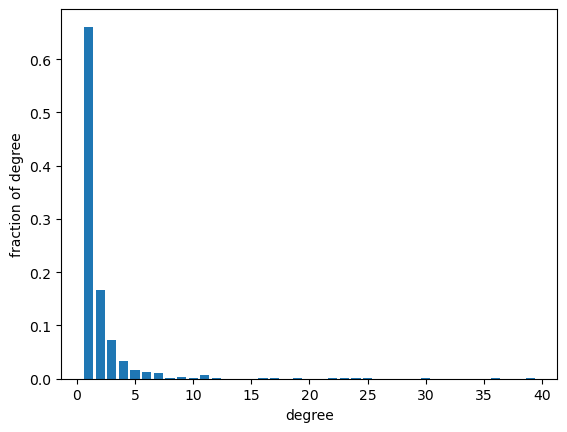

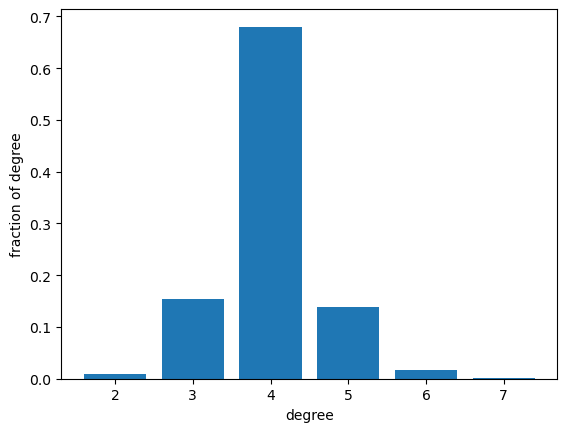

In [92]:
ans_one = graph_identification()
assert type(ans_one) == list, "You must return a list"


---

## Part 2 - Company Emails

For the second part of this assignment you will be working with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagmentSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagmentSalary` indicates whether that person is receiving a managment position salary.

In [65]:
G = pickle.load(open('assets/email_prediction_NEW.txt', 'rb'))

print(f"Graph with {len(nx.nodes(G))} nodes and {len(nx.edges(G))} edges")

Graph with 1005 nodes and 16706 edges


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a managment position salary.

To accomplish this, you will need to create a matrix of node features of your choice using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a managment salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a managment position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a Pandas series of length 252 with the data being the probability of receiving managment salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [66]:
list(G.nodes(data=True))[:5] # print the first 5 nodes

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (581, {'Department': 3, 'ManagementSalary': 0.0}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (65, {'Department': 4, 'ManagementSalary': nan})]

In [111]:
def salary_predictions():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, roc_auc_score


    # YOUR CODE HERE
    df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
    test = df[df['ManagementSalary'].isnull()]
    df = df.dropna(subset=['ManagementSalary'])
    
    #feature engineering
    betweenness = nx.betweenness_centrality(G,normalized=True,k=10)
    degree_cent = nx.degree_centrality(G)
    closeness = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G)
    
    df['degree'] =df.index.map(lambda x: G.degree(x))
    df['degree centrality'] = df.index.map(lambda x: degree_cent[x])
    df['closeness'] = df.index.map(lambda x: closeness[x])
    df['betweenness'] = df.index.map(lambda x: betweenness[x])
    df['pagerank'] = df.index.map(lambda x: pagerank[x])

    # train_set &CV set split
    X = df.drop(['ManagementSalary'], axis = 1)
    Y = df['ManagementSalary']
    X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size =0.2,random_state = 30)
    
    # Train Random Forest model
    RF = RandomForestClassifier()
    trained_RF = RF.fit(X_train,y_train)
    
    # AUC
    print(roc_auc_score(y_test,trained_RF.predict_proba(X_test)[:, 1]))
    
    # Engineer features for nodes to be predicted
    test['degree'] =test.index.map(lambda x: G.degree(x))
    test['degree centrality'] = test.index.map(lambda x: degree_cent[x])
    test['closeness'] = test.index.map(lambda x: closeness[x])
    test['betweenness'] = test.index.map(lambda x: betweenness[x])
    test['pagerank'] = test.index.map(lambda x: pagerank[x])    
    
    X_predict = test.drop(['ManagementSalary'], axis = 1)
    #Predict Management Salary for the nodes in predicting group
    
    predict_proba = trained_RF.predict_proba(X_predict)[:, 1]

    return pd.Series(predict_proba,test.index)                        
    raise NotImplementedError()

In [112]:
ans_salary_preds = salary_predictions()
assert type(ans_salary_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_salary_preds) == 252, "The series must be of length 252"


0.9181299385425812


### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [86]:
future_connections = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to:      
1. Create a matrix of features of your choice for the edges found in `future_connections` using Networkx     
2. Train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data     
3. Predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [125]:
def new_connections_predictions():
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, roc_auc_score

    # YOUR CODE HERE
    # Split dataframe
    test = future_connections[future_connections['Future Connection'].isnull()]
    train = future_connections.dropna(subset = ['Future Connection'])
    
    
    # Feature Engineering for training set
    train['pref_attachment'] = [list(nx.preferential_attachment(G, [pair]))[0][2]
                                             for pair in train.index]
    train['common neighbors'] = [len(list(nx.common_neighbors(G, pair[0], pair[1]))) 
                                            for pair in train.index]
    train['jaccard coefficient'] = [list(nx.jaccard_coefficient(G, [pair]))[0][2]
                                              for pair in train.index]
    train['adamic adar index'] = [list(nx.adamic_adar_index(G, [pair]))[0][2]
                                              for pair in train.index]
    train['resource allocation index'] = [list(nx.resource_allocation_index(G, [pair]))[0][2]
                                              for pair in train.index]

    #Create training set and CV set
    X = train.drop(['Future Connection'],axis =1)
    Y = train['Future Connection']
    
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state = 30)
    
    # Train Random Forest model
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    
    # AUC
    print(roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1]))
    
    # Create the set to be predicted
    test['pref_attachment'] = [list(nx.preferential_attachment(G, [pair]))[0][2]
                                             for pair in test.index]
    test['common neighbors'] = [len(list(nx.common_neighbors(G, pair[0], pair[1]))) 
                                            for pair in test.index]
    test['jaccard coefficient'] = [list(nx.jaccard_coefficient(G, [pair]))[0][2]
                                              for pair in test.index]
    test['adamic adar index'] = [list(nx.adamic_adar_index(G, [pair]))[0][2]
                                              for pair in test.index]
    test['resource allocation index'] = [list(nx.resource_allocation_index(G, [pair]))[0][2]
                                              for pair in test.index]
    
    X_predict = test.drop(['Future Connection'], axis =1)
    
    # Predict and return a series with preidct_proba
    predict_proba = clf.predict_proba(X_predict)[:, 1]
    
    return pd.Series(predict_proba,test.index)
    raise NotImplementedError()

In [126]:
ans_prob_preds = new_connections_predictions()
assert type(ans_prob_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_prob_preds) == 122112, "The series must be of length 122112"


0.9102814882626243


In [72]:
degree = dict(G2.degree())
G_value = sorted(set(degree.values()))
hist = [list(degree.values()).count(i)/float(nx.number_of_nodes(G2))
                                                    for i in G_value]

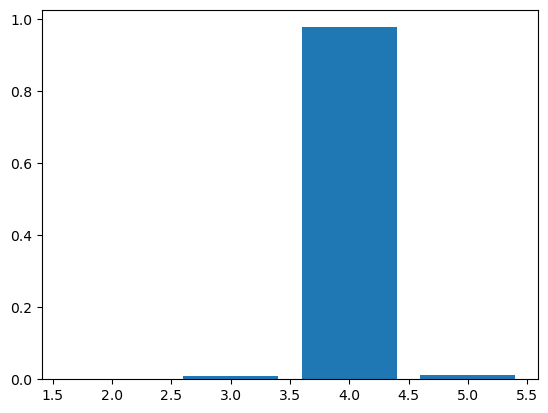

In [73]:
import matplotlib.pyplot as plt
plt.bar(G_value,hist)
plt.show()

max(hist)

In [93]:
ans_one

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

In [83]:
nx.average_clustering(G5)

0.36504285714285717

In [86]:
nx.average_shortest_path_length(G2)

43.80284684684685